# Problem 3 Naive Bayes

## 3.1 implement a Naive Bayes classifier

In [1]:
import sys
import itertools
from collections import Counter
import numpy as np
from matplotlib import pyplot as plt
import time
from copy import deepcopy

In [2]:
class Model:
    def __init__(self, wordlist):
        self.wordlist = wordlist

    def count_labels(self, data):
        """
        Count the number of positive labels and negative labels.
        Returns (a tuple or a numpy array of two elements):
            * negative_count: a non-negative integer, which represents the number of negative labels (non-spam emails);
            * positive_count: a non-negative integer, which represents the number of positive labels (spam emails).
        """
        # TODO
        c = Counter(data[:,0])
        return np.array([c[0], c[1]])

    def count_words(self, wordlist, data):
        """
        Count the number of times that each word appears in emails under a given label.
        Returns (a numpy array):
            * word_counts: a numpy array with shape (2, L), where L is the length of $wordlist,
                - word_counts[0, i] represents the number of times that word $wordlist[i] appears in non-spam (negative) emails, and
                - word_counts[1, i] represents the number of times that word $wordlist[i] appears in spam (positive) emails.
        """
        L = len(wordlist)
        spam = data[data[:,0]==1][:,1]
        non_spam = data[data[:,0]==0][:,1]
        
        output = np.zeros(2*L).reshape(2, L)
        
        for mail in non_spam:
            mail = set(mail)
            for i in range(L):
                if wordlist[i] in mail:
                    output[0, i] += 1
            
        for mail in spam:
            mail = set(mail)
            for j in range(L):
                if wordlist[j] in mail:
                    output[1, j] += 1
        
        return output
            

    def calculate_probability(self, label_counts, word_counts):
        """
        Calculate the probabilities, both the prior and likelihood.
        Returns (a pair of numpy array):
            * prior_probs: a numpy array with shape (2, ), only two elements, where
                - prior_probs[0] is the prior probability of negative labels, and
                - prior_probs[1] is the prior probability of positive labels.
            * likelihood_probs: a numpy array with shape (2, L), where L is the length of the word list,
                - likelihood_probs[0, i] represents the likelihood probability of the $i-th word in the word list, given that the email is non-spam (negative), and
                - likelihood_probs[1, i] represents the likelihood probability of the $i-th word in the word list, given that the email is spam (positive).
        """
        # TODO
        prior_probs = deepcopy(label_counts)/sum(label_counts)
        
        L = word_counts.shape[1]
        likelihood_probs = np.zeros(2*L).reshape(2, L)
        
        for i in range(L):
            likelihood_probs[0, i] = (word_counts[0, i] + 1)/(label_counts[0] + 2)
            likelihood_probs[1, i] = (word_counts[1, i] + 1)/(label_counts[1] + 2)
            
        return prior_probs, likelihood_probs

    def fit(self, data):
        label_counts = self.count_labels(data)
        word_counts = self.count_words(self.wordlist, data)

        self.prior_probs, self.likelihood_probs = self.calculate_probability(label_counts, word_counts)

        # TO AVOID NUMBER OVERFLOW here we use log probability instead.
        
        self.log_prior_probs = np.log(self.prior_probs)
        self.log_likelihood_probs = np.dstack([np.log(1 - self.likelihood_probs), np.log(self.likelihood_probs)])

    def predict(self, x):
        """
        Predict whether email $x is a spam or not.
        Returns:
            * y: a boolean value indicating whether $x is a spam or not.
        """        
        # proc the data
        L = len(self.wordlist)
        feature_vector = np.zeros(L, dtype="int8")
        word_set = set(x)
        for i in range(L):
            if self.wordlist[i] in word_set:
                feature_vector[i] = 1
        
        neg, pos = self.log_prior_probs[0], self.log_prior_probs[1]
        
        for i in range(L):
            neg += self.log_likelihood_probs[0, i, feature_vector[i]]
            pos += self.log_likelihood_probs[1, i, feature_vector[i]]
        
        if pos > neg:
            return 1
        else:
            return 0
            
        

In [3]:
def read_data(filename):
    """
    Read the dataset from the file given by name $filename.
    The returned object should be a list of pairs of data. In each pair: the first element is 1 (for spam emails) 
    or 0 (for non-spam emails), the second element is a list of words in the email.
    The returned list: 
        [
            (1 , ['a', 'b', 'c']),
            (0, ['d', 'e', 'f']),
            ...
        ]
    """
    f = open(filename, "r")
    data_list = f.read().split()
    seperator = []
    
    for i in range(len(data_list)):
        if data_list[i] in "01":
            seperator.append(i)
            
    data_list.append("end")
    seperator.append(-1)
    
    output = []
    
    for j in range(len(seperator) - 1):
        output.append([int(data_list[seperator[j]]), data_list[seperator[j]+1:seperator[j+1]]])
    
    return np.array(output)
        
    

def split_train(original_train_data, size=4000):
    return original_train_data[:size], original_train_data[size:]


def create_wordlist(original_train_data, threshold=26):
    """
    Create a word list from the original training set.
    Only get a word if it appears in at least $threshold emails.
    Returns:
        * a python list containing all the words that occur in at least $threshold emails.
    """
    c = Counter()
    for i in original_train_data:
        c.update(list(set(i[1])))

    c = dict(c)
    c = {k:v for k,v in c.items() if v >= threshold}
    
    return list(c.keys())

In [4]:
# threshold to determine whether to include a word in the dictionary/wordlist.
# ie. only words with frequency higher than threshold are included
THRESHOLD = 2

In [5]:
original_train_data = read_data('spam_train.txt')

# further split the data into a training set and a validation set
train_data, val_data = split_train(original_train_data)

# Create the word list.
wordlist = create_wordlist(original_train_data, 26)
print("Total # of words:", len(wordlist))


# fit the model using train_data
model = Model(wordlist)
model.fit(train_data)





Total # of words: 3048


In [6]:
# TODO
# calculate the error rate on val_data (when threshold=26)
# print out the error rate
error_count = 0
total = len(val_data)
for mail in val_data:
    if mail[0] != model.predict(mail[1]):
        error_count += 1
        
error_percentage = error_count*100/total
    

print("Validation error, # = {:>4d}, % = {:>8.4f}%.".format(error_count, error_percentage))

Validation error, # =   61, % =   6.1000%.


## 3.2 try different thresholds, find the optimal threshold (which gives minimum validation error), print out the test error at the optimal threshold

In [7]:
def compute_error_rate(model, data):
    
    error_count = sum([y != model.predict(x) for y, x in data])
    return 100.0 * error_count / len(data)

In [8]:
thresholds = list(range(1, 35))
train_error = []
val_error = []
test_error = []
original_train_data = read_data('spam_train.txt')
train_data, val_data = split_train(original_train_data)
test_data = read_data('spam_test.txt')

In [9]:
for th in thresholds:
    print('With threshold {}....'.format(th))
    time1 = time.time()

    # vocabulary selection
    wordlist = create_wordlist(original_train_data, th)

    # fit model using the wordlist
    model = Model(wordlist)
    model.fit(train_data)

    # compute classification error rates
    err_train = compute_error_rate(model, train_data)
    err_val = compute_error_rate(model, val_data)
    err_test = compute_error_rate(model, test_data)

    # store results for plotting
    train_error.append(err_train)
    val_error.append(err_val)
    test_error.append(err_test)

    time2 = time.time()
    print("train:{} val:{} test:{} len(V)={}".format(err_train, err_val, err_test, len(wordlist)))
    print('time: {}'.format(time2 - time1))

With threshold 1....
train:12.275 val:14.7 test:16.5 len(V)=65812
time: 449.88518929481506
With threshold 2....
train:4.45 val:6.1 test:7.3 len(V)=19298
time: 127.00641798973083
With threshold 3....
train:4.0 val:5.4 test:5.9 len(V)=12882
time: 83.80729103088379
With threshold 4....
train:3.975 val:5.5 test:5.3 len(V)=10362
time: 69.61683392524719
With threshold 5....
train:3.95 val:5.5 test:5.2 len(V)=8773
time: 55.15819311141968
With threshold 6....
train:4.1 val:5.6 test:5.4 len(V)=7803
time: 48.61394786834717
With threshold 7....
train:4.225 val:5.5 test:5.4 len(V)=7085
time: 45.021509885787964
With threshold 8....
train:4.2 val:5.1 test:5.5 len(V)=6493
time: 41.55952000617981
With threshold 9....
train:4.4 val:5.1 test:6.0 len(V)=5982
time: 38.53121733665466
With threshold 10....
train:4.55 val:5.0 test:6.1 len(V)=5603
time: 36.81209588050842
With threshold 11....
train:4.55 val:5.1 test:6.2 len(V)=5303
time: 35.03451108932495
With threshold 12....
train:4.625 val:5.0 test:6.2 len

Best performance at validated threshold 10 with test error rate 6.1.


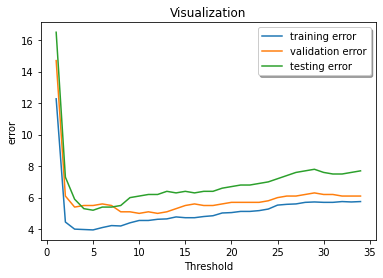

In [10]:
# plot the training and validation error rate vs. the thresholds
# choose the threshold with the minimal validation error rate and report the corresponding test error rate

# TODO

fig, ax = plt.subplots()
ax.set_xlabel('Threshold')
ax.set_ylabel('error')
ax.set_title("Visualization")


ax.plot(thresholds, train_error, label='training error')
ax.plot(thresholds, val_error, label='validation error')
ax.plot(thresholds, test_error, label='testing error')

legend = ax.legend(loc="best", shadow=True)


opt = np.argmin(val_error)
print('Best performance at validated threshold {} with test error rate {}.'.format(opt+1, test_error[opt]))